In [174]:
%reset -sf

In [175]:
from collections import defaultdict

import math
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pandas as pd
import pyro
from pyro.contrib.autoguide import *
import pyro.distributions as dist
from pyro.infer import SVI, Trace_ELBO, JitTrace_ELBO
import pyro.optim as optim
import pyro.poutine as poutine
import seaborn as sns
import torch
from torch.distributions.transforms import ExpTransform

%matplotlib inline
plt.rcParams["figure.figsize"] = (12, 6)

print('pyro ver: {}'.format(pyro.__version__))
print('pytorch ver: {}'.format(torch.__version__))

plt.rcParams.update({'font.size': 16,
                     'xtick.labelsize': 14,
                     'ytick.labelsize': 14,
                     'axes.titlesize': 'large', 
                     'axes.labelsize': 'medium'})

pyro ver: 0.4.0
pytorch ver: 1.2.0


## Dataset

Weekly unemployment insurance claim dataset that is provided by the Department of Labor (https://oui.doleta.gov/unemploy/claims.asp).

In [176]:
unemployment = pd.read_csv('data/unemployment_claims.csv')
unemployment['date'] = pd.to_datetime(unemployment['date'])
unemployment

,date,initial claim
0,2010-01-02,651215
1,2010-01-09,825891
2,2010-01-16,659173
3,2010-01-23,507651
4,2010-01-30,538617
5,2010-02-06,512463
6,2010-02-13,482078
7,2010-02-20,458160
8,2010-02-27,474662
9,2010-03-06,462679


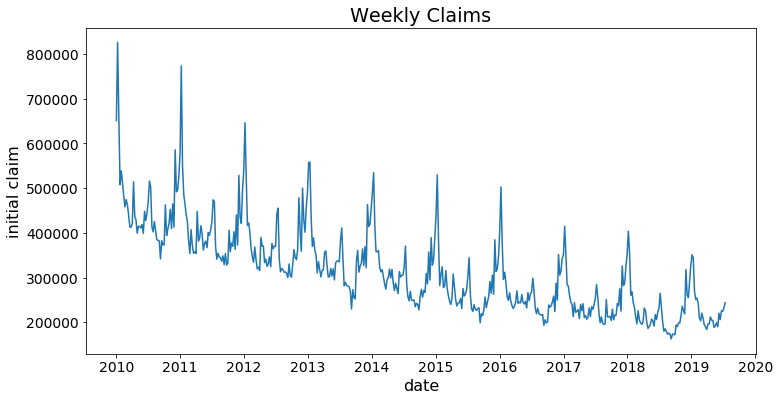

In [177]:
y = torch.tensor(unemployment['initial claim'].values, dtype=torch.float32)
y_train = y[:-200]


fig, ax = plt.subplots()
sns.lineplot(x='date', y='initial claim', data=unemployment, ax=ax).set_title('Weekly Claims');

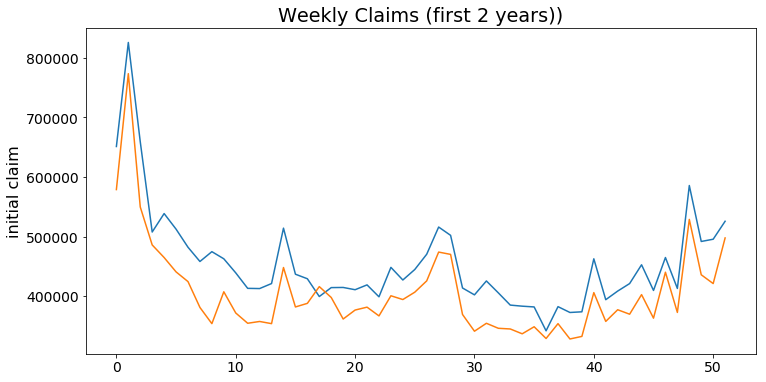

In [178]:
fig, ax = plt.subplots()
sns.lineplot(x=np.arange(52), y='initial claim', data=unemployment[:52], ax=ax).set_title('Weekly Claims (first 2 years))');
sns.lineplot(x=np.arange(52), y='initial claim', data=unemployment[52:104], ax=ax);

In [179]:
init_date = '2010-01-02'

## Seasonal Global Trend Models

Given some data, $y$ with seasonality $S$; at time $t$, the parameters of the Seasonal Global Trend (SGT) model are updated as follows, to generate the predicted $\tilde{y}_{t+1}$. 

$$
\begin{align}
\tilde{y}_{t+1} & \sim t(\nu, \hat{y}_{t+1}, \hat{\sigma}_{t+1}) \\
\hat{y}_{t+1} & = (l_t + \gamma l_{t}^{\tau_{trend}}) s_{t+1} \\
\hat{\sigma}_{t+1} &= \sigma \hat{y}_{t+1}^{\tau_{var}} \\
l_{t+1} &= \alpha \frac{y_t}{s_t} + (1 - \alpha) l_t \\
s_{t+1+S} &= \beta \frac{y_{t+1}}{l_{t+1}} + (1 - \beta) s_{t+1} \\
\end{align}
$$

We place appropriate priors on $\nu$, $\alpha$, $\beta$, $\gamma$, $\sigma$, $\tau_{trend}$ and $\tau_{var}$.

### Model specification in Pyro

Reformulate to vectorize update equations for `l`, `s` along windows of seasonality `S`.

$$
\begin{align}
l_{i:i+S} &= \alpha \begin{bmatrix}
1 & 0 & 0 & 0 \\
1-\alpha & 1 & 0 & 0 \\
1-\alpha^2 & 1-\alpha & 1 & 0 \\
1-\alpha^3 & 1-\alpha^2 & 1-\alpha & 1 \\
\end{bmatrix} (\frac{y}{s})_{i-1:i+S-1}
\\
s_{i+S:i+2S} &= \beta \begin{bmatrix}
1 & 0 & 0 & 0 \\
1-\beta & 1 & 0 & 0 \\
1-\beta^2 & 1-\beta & 1 & 0 \\
1-\beta^3 & 1-\beta^2 & 1-\beta & 1 \\
\end{bmatrix} (\frac{y}{l})_{i:i+S}
\end{align}
$$

In [180]:
def construct_exp_tril(factor, S):
    exps = lambda i: torch.arange(i-1, -1, -1, dtype=factor.dtype, device=factor.device)
    tril = torch.stack([torch.cat([(1 - factor) ** exps(i), torch.zeros(S-i)])
                        for i in range(1, S+1)])
    assert (tril.diag() == 1).all()
    return factor * tril

In [181]:
def window_predict(alpha, beta, y_obs, seasonality, d_last):
    d_window = y_obs / seasonality
    d_window_prev = torch.cat([d_last.unsqueeze(-1), d_window[:-1]])
    level_cur = alpha @ d_window_prev
    seasonality_next = beta @ (y_obs / level_cur)
    return level_cur, seasonality_next, d_window[-1]

def model_sgt(periodicity, y):
    """
    A bayesian model for time series forecasting using Seasonal Global Trend (SGT).
     - Note that `tau_var` is assumed to be 0.
    """
    S = periodicity
    nu = pyro.sample('nu', dist.Uniform(2, 20))
    sigma = pyro.sample('sigma', dist.HalfCauchy(100.))
    alpha = pyro.sample('alpha', dist.Beta(2., 2.)) 
    beta = pyro.sample('beta', dist.Beta(2., 2.))
    gamma = pyro.sample('gamma', dist.Normal(0., 1.))
    pow_trend = pyro.sample('pow_trend', dist.Beta(1., 2.))
    
    with pyro.plate('init_s', S):
        init_seasonality = pyro.sample('init_seasonality', dist.LogNormal(0., 1.))
        
    alpha_tril = construct_exp_tril(alpha, S)
    beta_tril = construct_exp_tril(beta, S)
    
    seasonality = [init_seasonality]
    level = []
    d_last = l_last = y[0] / init_seasonality[0]
    
    for i in range(math.ceil(len(y) / S)):
        s, e = i * S, min((i+1) * S, len(y))
        window_len = e - s
        y_obs = y[s:e]
        seasonality_cur = seasonality[-1][:window_len]
                    
        if window_len < S:
            alpha_tril = construct_exp_tril(alpha, window_len)
            beta_tril = construct_exp_tril(beta, window_len)                    
            
        level_cur, seasonality_next, d_last = window_predict(alpha_tril, beta_tril, 
                                                             y_obs, seasonality_cur, d_last)
        level_prev = torch.cat([l_last.unsqueeze(-1), level_cur[:-1]])
        y_hat = (level_prev + gamma * level_prev ** pow_trend) * seasonality_cur
        with pyro.plate('obs_window_{}'.format(i), window_len):
            y_pred = pyro.sample('y_{}'.format(i), dist.StudentT(nu, y_hat, sigma), obs=y_obs)
        l_last = level_cur[-1]
        level.append(level_cur)
        seasonality.append(seasonality_next)
        
    return torch.cat([l.detach() for l in level]), torch.cat([s.detach() for s in seasonality])

## Inference Using Automatic Variational Inference

### MAP Inference using a Delta Autoguide

In [182]:
pyro.clear_param_store()
pyro.set_rng_seed(1)
guide_autodelta = AutoDelta(model_sgt)
opt = optim.Adam({'lr': 0.08})

In [184]:
%%time

svi = SVI(model_sgt, guide_autodelta, opt, loss=Trace_ELBO())
periodicity = 52  # Use yearly periodicity

for i in range(800):
    loss = svi.step(periodicity, y_train)
    if i % 100 == 0:
        print('ELBO loss: {}'.format(loss))
print('ELBO loss: {}'.format(loss))

ELBO loss: 3476.74414986372
ELBO loss: 3473.9019377827644
ELBO loss: 3471.634963154793
ELBO loss: 3469.601225435734
ELBO loss: 3467.8139349222183
ELBO loss: 3466.2754607200623
ELBO loss: 3464.975737810135
ELBO loss: 3463.8943628668785
ELBO loss: 3463.015981376171
CPU times: user 15.4 s, sys: 22.6 ms, total: 15.4 s
Wall time: 15.4 s


### Prediction

In [185]:
@torch.no_grad()
def sgt_predict(level, seasonality, num_steps=100, **params):
    """
    Forecasting function to forecast `num_steps` ahead.
    """
    level, seasonality = list(level), list(seasonality)
    y_preds = []
    start_idx = len(level)
    for i in range(start_idx, start_idx + num_steps):
        level_prev = level[-1]
        seasonality_cur = seasonality[i]
        assert seasonality_cur > 0
        y_hat = (level_prev + params['gamma'] * level_prev ** params['pow_trend']) * seasonality_cur
        y_pred = pyro.sample('y_{}'.format(i),
                             dist.StudentT(params['nu'], y_hat, params['sigma'])).clamp(min=0.)
        level_cur = params['alpha'] * (y_pred / seasonality_cur) + (1 - params['alpha']) * level_prev
        seasonality_next = params['beta'] * (y_pred / level_cur) + (1 - params['beta']) * seasonality_cur
        y_preds.append(y_pred)
        level.append(level_cur)
        seasonality.append(seasonality_next)

    return torch.stack(y_preds, -1), torch.stack(level,-1), torch.stack(seasonality, -1)


In [186]:
def forecast(model, guide, *model_args, predict_ahead=100, num_samples=100):
    preds_acc, level_acc, seasonality_acc = [], [], []
    for i in range(num_samples):
        guide_trace = poutine.trace(guide).get_trace(*model_args)
        
        # replay from guide trace to get current level, seasonality
        level, seasonality = poutine.replay(model, guide_trace)(*model_args)
        guide_params = {site: node['value'] for site, node in guide_trace.iter_stochastic_nodes()}
        # forecast ahead
        pred, level, seasonality = sgt_predict(level, seasonality, num_steps=200, **guide_params)
        preds_acc.append(pred)
        level_acc.append(level)
        seasonality_acc.append(seasonality)
    return torch.stack(preds_acc), torch.stack(level_acc), torch.stack(seasonality_acc)

In [187]:
num_samples = 200
predict_ahead = 200
preds, level, seasonality = forecast(model_sgt, guide_autodelta, periodicity, y_train, 
                                     predict_ahead=predict_ahead, num_samples=num_samples)

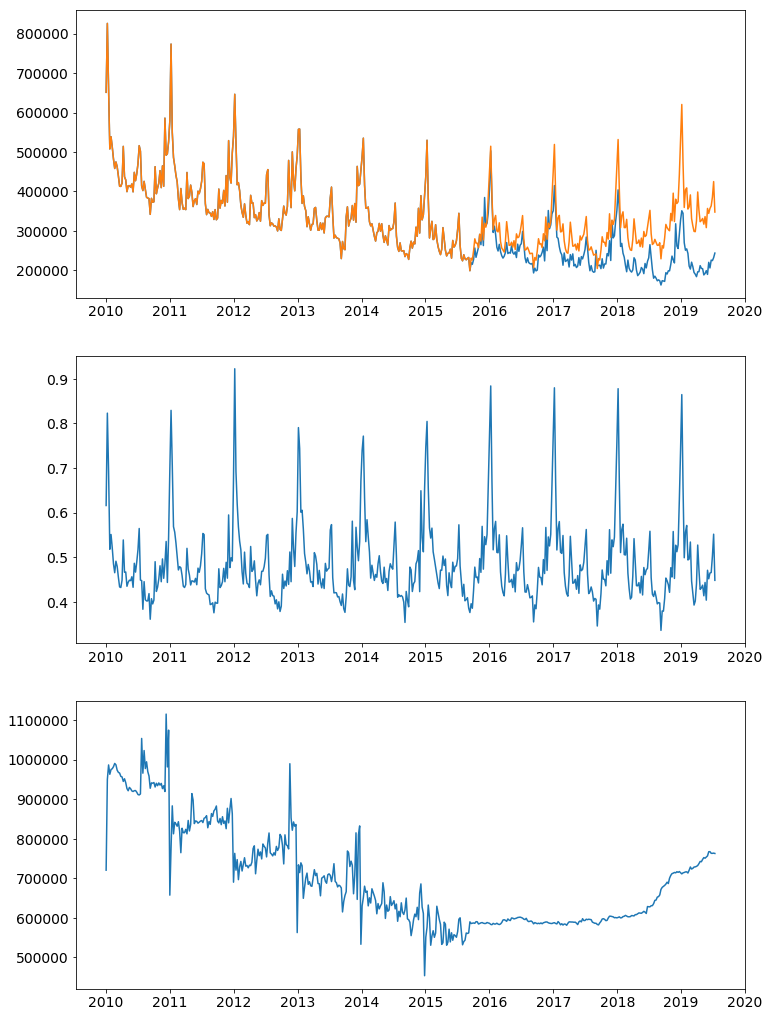

In [192]:
x_range = len(y_train) + predict_ahead
time_range = pd.date_range(start=init_date, freq='7D', 
                                periods=x_range)
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(12, 18))
ax[0].plot(time_range, y);
ax[0].plot(time_range, torch.cat([y_train, preds.mean(0)]));
ax[1].plot(time_range, seasonality[:, :x_range].mean(0));
ax[2].plot(time_range, level.mean(0));

In [193]:
guide_autodelta(y_train, periodicity)

{'nu': tensor(2.3051, grad_fn=<ExpandBackward>),
 'sigma': tensor(12965.1631, grad_fn=<ExpandBackward>),
 'alpha': tensor(0.6813, grad_fn=<ExpandBackward>),
 'beta': tensor(0.7693, grad_fn=<ExpandBackward>),
 'gamma': tensor(-0.0002, grad_fn=<ExpandBackward>),
 'pow_trend': tensor(0.0001, grad_fn=<ExpandBackward>),
 'init_seasonality': tensor([0.6160, 0.8232, 0.6927, 0.5178, 0.5509, 0.5207, 0.4850, 0.4652, 0.4910,
         0.4795, 0.4550, 0.4333, 0.4320, 0.4483, 0.5387, 0.4662, 0.4668, 0.4348,
         0.4439, 0.4484, 0.4474, 0.4561, 0.4325, 0.4864, 0.4665, 0.4894, 0.5170,
         0.5644, 0.4487, 0.4475, 0.3832, 0.4452, 0.4046, 0.4019, 0.4020, 0.4183,
         0.3608, 0.4069, 0.3952, 0.4039, 0.4899, 0.4232, 0.4327, 0.4515, 0.4808,
         0.4450, 0.4961, 0.4527, 0.4855, 0.5353, 0.4433, 0.5451],
        grad_fn=<ExpandBackward>)}

### SVI using a Diagonal Normal Autoguide

In [195]:
pyro.clear_param_store()
pyro.set_rng_seed(1)
guide_diagnormal = AutoDiagonalNormal(model_sgt)
opt = optim.Adam({'lr': 0.05})

In [197]:
%%time

svi = SVI(model_sgt, guide_diagnormal, opt, loss=Trace_ELBO())
periodicity = 52  # Use yearly periodicity

for i in range(800):
    loss = svi.step(periodicity, y_train)
    if i % 100 == 0:
        print('ELBO loss: {}'.format(loss))
print('ELBO loss: {}'.format(loss))

ELBO loss: 16732.77827090025
ELBO loss: 7448.758342266083
ELBO loss: 4344.109744012356
ELBO loss: 3851.266083717346
ELBO loss: 3777.903049826622
ELBO loss: 3800.4512273669243
ELBO loss: 3728.887205541134
ELBO loss: 3748.891195178032
ELBO loss: 3721.8553590625525
CPU times: user 17.5 s, sys: 41.6 ms, total: 17.5 s
Wall time: 17.5 s


In [201]:
num_samples = 200
predict_ahead = 200
preds, level, seasonality = forecast(model_sgt, guide_autodelta, periodicity, y_train, 
                                     predict_ahead=predict_ahead, num_samples=num_samples)

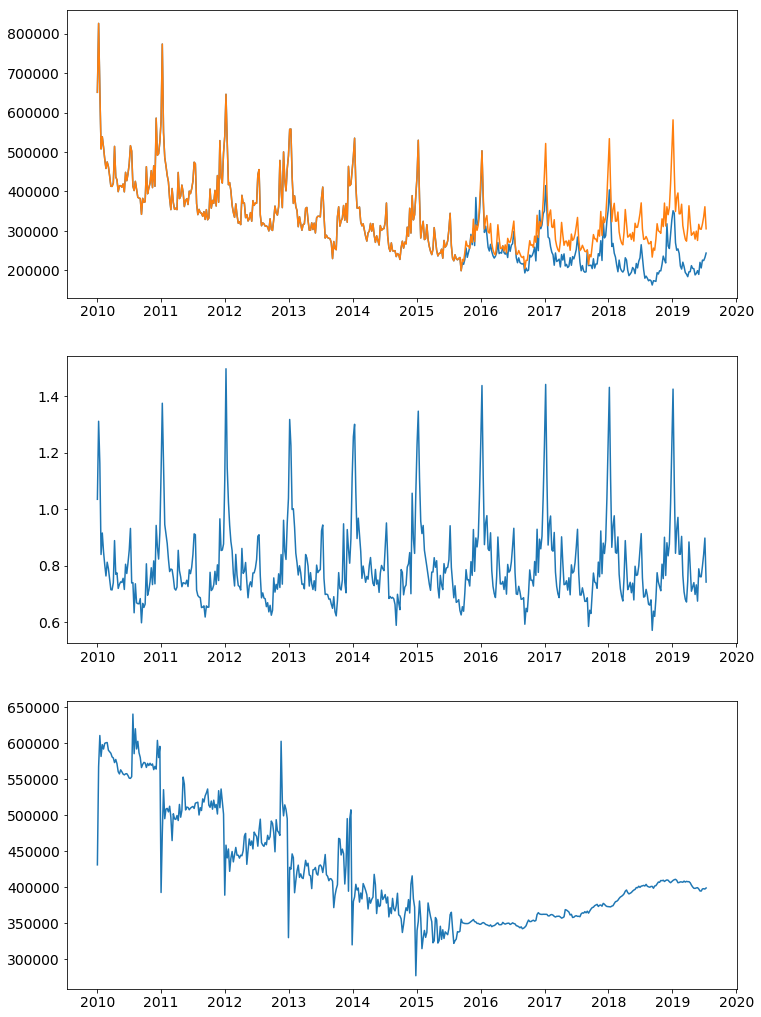

In [202]:
x_range = len(y_train) + predict_ahead
time_range = pd.date_range(start=init_date, freq='7D', 
                                periods=x_range)
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(12, 18))
ax[0].plot(time_range, y);
ax[0].plot(time_range, torch.cat([y_train, preds.mean(0)]));
ax[1].plot(time_range, seasonality[:, :x_range].mean(0));
ax[2].plot(time_range, level.mean(0));

In [161]:
guide_diagnormal.quantiles([0.2, 0.5, 0.8])

{'nu': [tensor(2.1404, grad_fn=<AddBackward0>),
  tensor(2.1930, grad_fn=<AddBackward0>),
  tensor(2.2649, grad_fn=<AddBackward0>)],
 'sigma': [tensor(20413.7227, grad_fn=<AddBackward0>),
  tensor(27564.6094, grad_fn=<AddBackward0>),
  tensor(37220.4414, grad_fn=<AddBackward0>)],
 'alpha': [tensor(0.0906, grad_fn=<ClampBackward>),
  tensor(0.1287, grad_fn=<ClampBackward>),
  tensor(0.1797, grad_fn=<ClampBackward>)],
 'beta': [tensor(0.8875, grad_fn=<ClampBackward>),
  tensor(0.9187, grad_fn=<ClampBackward>),
  tensor(0.9419, grad_fn=<ClampBackward>)],
 'gamma': [tensor(-0.8141, grad_fn=<ViewBackward>),
  tensor(-0.0661, grad_fn=<ViewBackward>),
  tensor(0.6819, grad_fn=<ViewBackward>)],
 'pow_trend': [tensor(0.0619, grad_fn=<ClampBackward>),
  tensor(0.1166, grad_fn=<ClampBackward>),
  tensor(0.2086, grad_fn=<ClampBackward>)],
 'init_seasonality': [tensor([1.0532, 1.1448, 0.8065, 0.7538, 0.6894, 0.6430, 0.5636, 0.6192, 0.5194,
          0.6159, 0.7402, 0.4095, 0.5378, 0.5623, 0.5341, 0